https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/


In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import glob

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
files = glob.glob('../documents/questions/*.txt')

In [3]:
print(len(files))

126172


In [4]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [6]:
data = []

for f in files:
    with open(f, 'r') as fin:
        data.append(fin.read())

In [7]:

data_words = list(sent_to_words(data))



In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/Users/wickes1/anaconda/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['darth', 'vader', 'has', 'he', 'been', 'forgotten', 'so', 'quickly', 'surely', 'his', 'death', 'star', 'has', 'an', 'appeal', 'to', 'the', 'billionaires', 'who', 'vote', 'sorry', 'buy', 'the', 'offices', 'in', 'the', 'us', 'think', 'of', 'the', 'profits', 'to', 'be', 'made', 'in', 'financing', 'that', 'project']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out



In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
nlp.max_length = 9297925
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['darth', 'vader', 'forget', 'quickly', 'surely', 'death', 'star', 'appeal', 'billionaire', 'vote', 'sorry', 'buy', 'office', 'think', 'profit', 'make', 'financing', 'project']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]


In [12]:
id2word[0]

'appeal'

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(30))
doc_lda = lda_model[corpus]

[(0,
  '0.062*"change" + 0.038*"college" + 0.033*"benefit" + 0.030*"group" + '
  '0.027*"small" + 0.023*"employee" + 0.022*"datum" + 0.021*"break" + '
  '0.020*"decade" + 0.018*"rise"'),
 (1,
  '0.044*"price" + 0.036*"choice" + 0.035*"voter" + 0.033*"easy" + '
  '0.032*"technology" + 0.024*"isis" + 0.023*"ignore" + 0.022*"wait" + '
  '0.022*"strong" + 0.017*"bush"'),
 (2,
  '0.111*"right" + 0.075*"look" + 0.074*"man" + 0.040*"family" + 0.040*"must" '
  '+ 0.033*"idea" + 0.022*"rest" + 0.021*"situation" + 0.019*"thank" + '
  '0.017*"die"'),
 (3,
  '0.061*"know" + 0.052*"even" + 0.029*"never" + 0.026*"day" + 0.023*"call" + '
  '0.022*"believe" + 0.022*"school" + 0.021*"anyone" + 0.019*"public" + '
  '0.019*"nothing"'),
 (4,
  '0.118*"pay" + 0.065*"greece" + 0.046*"worker" + 0.038*"cost" + 0.034*"debt" '
  '+ 0.027*"economy" + 0.026*"bank" + 0.021*"provide" + 0.019*"service" + '
  '0.018*"wage"'),
 (5,
  '0.070*"seem" + 0.063*"question" + 0.041*"talk" + 0.026*"ai" + '
  '0.024*"accept" + 

In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.027667963174588

Coherence Score:  0.391873697162595


In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
19     13.164618        1       1 -0.281936 -0.346560
29     11.172977        1       2 -0.252746  0.335945
3       6.598396        1       3 -0.150216  0.027502
10      6.336489        1       4 -0.143288  0.026882
9       3.991899        1       5 -0.050483  0.001875
18      3.588603        1       6 -0.023418  0.002105
11      3.572186        1       7 -0.024742  0.004372
23      3.065232        1       8 -0.002817  0.000584
21      3.041180        1       9 -0.021390  0.001460
4       3.037931        1      10 -0.080109  0.005891
2       3.016767        1      11  0.006799  0.001287
16      2.913600        1      12 -0.000689 -0.001057
6       2.784465        1      13  0.021543 -0.000609
7       2.620048        1      14  0.028748 -0.002591
5       2.566198        1      15  0.031777 -0.000367
24      2.399981        1      16  0.027911 -0.000834
0       2.382333        1      17  0.030226 -0.002276
15      2.179893        1      18  0.050974 -0.003700
28      2.055064        1      19  0.033948 -0.002018
27      2.028534        1      20  0.056572 -0.003427
25      2.024144        1      21  0.058544 -0.003015
20      1.992947        1      22  0.045943 -0.003726
12      1.979052        1      23  0.063796 -0.003752
14      1.923950        1      24  0.071567 -0.004451
1       1.814026        1      25  0.066945 -0.004722
8       1.691117        1      26  0.078371 -0.005100
17      1.684581        1      27  0.077114 -0.003691
26      1.576576        1      28  0.087342 -0.004434
13      1.512800        1      29  0.089785 -0.004919
22      1.284412        1      30  0.103928 -0.006653, topic_info=      Category          Freq         Term         Total  loglift  logprob
term                                                                     
92     Default  44287.000000       people  44287.000000  30.0000  30.0000
249    Default  41189.000000        would  41189.000000  29.0000  29.0000
51     Default  22589.000000          say  22589.000000  28.0000  28.0000
7      Default  32661.000000         make  32661.000000  27.0000  27.0000
77     Default  32628.000000          get  32628.000000  26.0000  26.0000
3077   Default  18771.000000          pay  18771.000000  25.0000  25.0000
1805   Default  17691.000000     american  17691.000000  24.0000  24.0000
237    Default  17401.000000        right  17401.000000  23.0000  23.0000
2521   Default  17109.000000        woman  17109.000000  22.0000  22.0000
304    Default  20976.000000         know  20976.000000  21.0000  21.0000
78     Default  27404.000000           go  27404.000000  20.0000  20.0000
15     Default  24834.000000        think  24834.000000  19.0000  19.0000
171    Default  23951.000000         time  23951.000000  18.0000  18.0000
332    Default  17810.000000         even  17810.000000  17.0000  17.0000
632    Default  17228.000000        money  17228.000000  16.0000  16.0000
163    Default  23450.000000         good  23450.000000  15.0000  15.0000
43     Default  12906.000000         live  12906.000000  14.0000  14.0000
172    Default  16266.000000          way  16266.000000  13.0000  13.0000
174    Default  22122.000000         work  22122.000000  12.0000  12.0000
101    Default  21952.000000         want  21952.000000  11.0000  11.0000
642    Default  12438.000000   government  12438.000000  10.0000  10.0000
103    Default  21436.000000         year  21436.000000   9.0000   9.0000
875    Default  11835.000000         look  11835.000000   8.0000   8.0000
2114   Default  11694.000000          man  11694.000000   7.0000   7.0000
90     Default  18570.000000         need  18570.000000   6.0000   6.0000
631    Default  14452.000000          may  14452.000000   5.0000   5.0000
1514   Default  10176.000000        greek  10176.000000   4.0000   4.0000
224    Default  19166.000000         many  19166.000000   3.0000   3.0000
96     De

In [17]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=25, id2word=id2word)

In [18]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(7,
  [('show', 0.039889991773402265),
   ('watch', 0.024283475347228477),
   ('hear', 0.011421159770135648),
   ('love', 0.01059249518113527),
   ('play', 0.010274239940432226),
   ('great', 0.009343493481772382),
   ('guy', 0.008520833708634325),
   ('tv', 0.008406742207250215),
   ('head', 0.008178559204481994),
   ('remember', 0.00816654957275735)]),
 (23,
  [('war', 0.044917785359735556),
   ('deal', 0.0347831170349585),
   ('iran', 0.028565203065378443),
   ('military', 0.015156829607899408),
   ('iraq', 0.014471264734330325),
   ('israel', 0.014194913002348989),
   ('isis', 0.013599693887312267),
   ('russia', 0.01293538683928021),
   ('support', 0.011186930688859837),
   ('obama', 0.010713944070661011)]),
 (20,
  [('year', 0.017210590026007645),
   ('science', 0.01558661025684049),
   ('water', 0.014118436664789003),
   ('datum', 0.012746143797116386),
   ('change', 0.010109423876697388),
   ('earth', 0.0096959382528135),
   ('scientist', 0.008041995757277947),
   ('climate_ch

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=31, step=1)

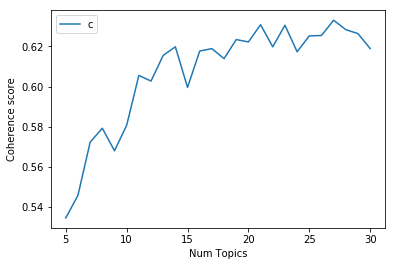

In [21]:
# Show graph
limit=31; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.5344
Num Topics = 6  has Coherence Value of 0.5457
Num Topics = 7  has Coherence Value of 0.5722
Num Topics = 8  has Coherence Value of 0.5792
Num Topics = 9  has Coherence Value of 0.5679
Num Topics = 10  has Coherence Value of 0.5806
Num Topics = 11  has Coherence Value of 0.6055
Num Topics = 12  has Coherence Value of 0.6027
Num Topics = 13  has Coherence Value of 0.6155
Num Topics = 14  has Coherence Value of 0.6198
Num Topics = 15  has Coherence Value of 0.5996
Num Topics = 16  has Coherence Value of 0.6177
Num Topics = 17  has Coherence Value of 0.6189
Num Topics = 18  has Coherence Value of 0.6139
Num Topics = 19  has Coherence Value of 0.6234
Num Topics = 20  has Coherence Value of 0.6223
Num Topics = 21  has Coherence Value of 0.6309
Num Topics = 22  has Coherence Value of 0.6198
Num Topics = 23  has Coherence Value of 0.6306
Num Topics = 24  has Coherence Value of 0.6174
Num Topics = 25  has Coherence Value of 0.6253
Num Topics = 26  h